In [1]:
%matplotlib inline
import pickle
import gzip

with gzip.open('./mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f,encoding ='latin-1')

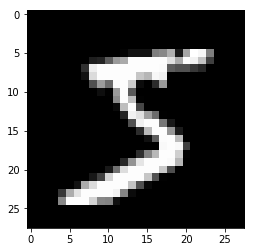

In [2]:
# plot a sample image
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(x_train[0].reshape([28,28]), cmap='gray')

In [3]:
#turn arrays into tensors
import torch
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape

In [4]:
y_train.min(), y_train.max()

(tensor(0), tensor(9))

In [5]:
weights = torch.randn(784,10) / np.sqrt(784)
weights.requires_grad = True
bias = torch.zeros(10)
bias.requires_grad = True

In [6]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

#define model
def model(xb):
    return log_softmax(xb @ weights + bias)

In [7]:
# make pred
bs = 64
xb = x_train[0:bs]
preds = model(xb)
print(preds[0], preds.shape)

#defin loss function (NLL)
def nll(logs, target): #negative log likelihood
    return -logs[range(target.shape[0]), target].mean()

loss_func = nll

tensor([-2.6667, -1.9164, -2.3723, -2.1379, -2.9910, -2.0952, -2.3489, -2.7188,
        -2.0681, -2.1977], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [8]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3248, grad_fn=<NegBackward>)


In [9]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [10]:
print(accuracy(preds,yb))

tensor(0.1094)


In [11]:
lr = 0.5
epochs = 2 
for epoch in range(epochs):
    for i in range((n-1) // bs+1):
        start_i = i * bs
        end_i = start_i + bs
        
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()


In [12]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0820, grad_fn=<NegBackward>) tensor(1.)


In [13]:
# use the cross entropy loss function
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [14]:
# confirm that our loss is the same 
print(loss_func(model(xb),yb))

tensor(0.0820, grad_fn=<NllLossBackward>)


In [15]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784,10)/np.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [16]:
model = Mnist_Logistic()

In [17]:
print(loss_func(model(xb), yb))

tensor(2.2406, grad_fn=<NllLossBackward>)


In [18]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // bs+1):
            start_i = i * bs
            end_i = start_i + bs

            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()

            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad() * lr
                model.zero_grad()

In [19]:
fit()

TypeError: 'Tensor' object is not callable

In [20]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784,10)
        
    def forward(self, xb):
        return self.lin(xb)

In [21]:
model = Mnist_Logistic()
print(loss_func(model(xb),yb))

tensor(2.4136, grad_fn=<NllLossBackward>)


In [22]:
fit()

TypeError: 'Tensor' object is not callable

In [24]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [27]:
model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n-1) // bs+1):
        start_i = i * bs
        end_i = start_i + bs
        
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        
        opt.step()
        opt.zero_grad()

tensor(2.3249, grad_fn=<NllLossBackward>)
